In [1]:
from ebmdatalab.bq import cached_read
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
vendors = pd.read_csv('vendors.csv')
# Clean up the input data
vendors['Principal Supplier'] = vendors['Principal Supplier'].str.strip()
vendors.loc[vendors['Principal Supplier'] == 'INPS', 'Principal Supplier'] = 'Vision'  # seems they changed in 2017
vendors = vendors.loc[vendors['Date'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this

In [6]:
from ebmdatalab import bq
import importlib
importlib.reload(bq)
measures = ['diltiazem']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.practice_id,
  m.pct_id,
  m.month,
  numerator,
  denominator,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} m
JOIN
  hscic.vendors software
ON
  software.ODS = practice_id
  AND Date = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = DATE(practice_statistics.month)
WHERE
  practices.setting = 4
  AND total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0
ORDER BY
  month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="data/diltiazem.csv.zip".format(measure_id))
    return df


df = get_data('diltiazem')

In [28]:
df['calc_value'] = df['numerator'] / df['denominator']
df['month'] = pd.to_datetime(df['month'])


Text(0.5, 1.0, 'diltiazem measure, mean values per supplier')

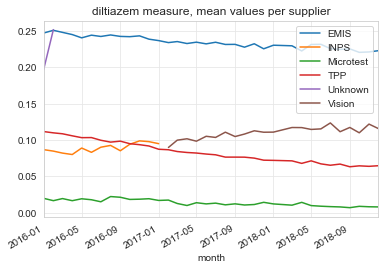

In [45]:
df.groupby(['month', 'supplier']).mean()['calc_value'].unstack().plot.line()
plt.legend(loc='best')
plt.title("diltiazem measure, mean values per supplier")

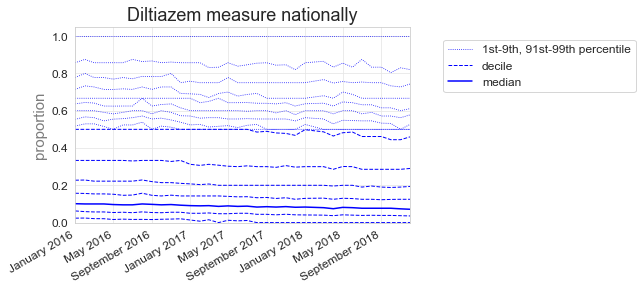

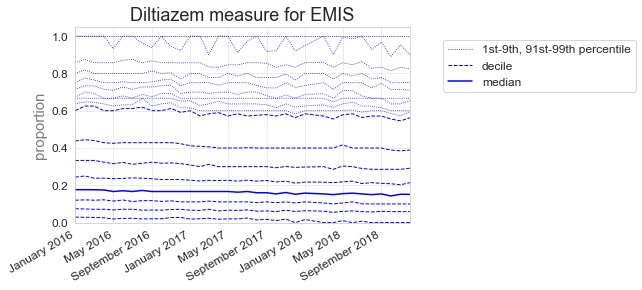

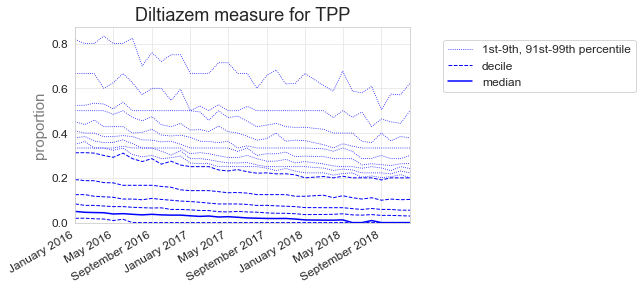

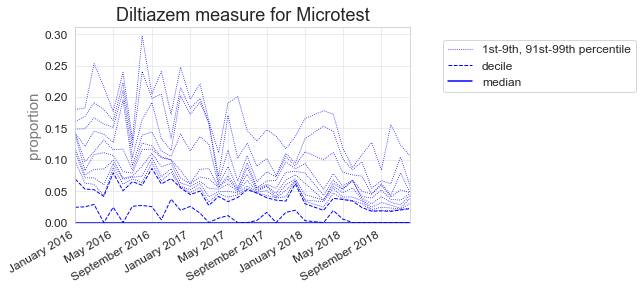

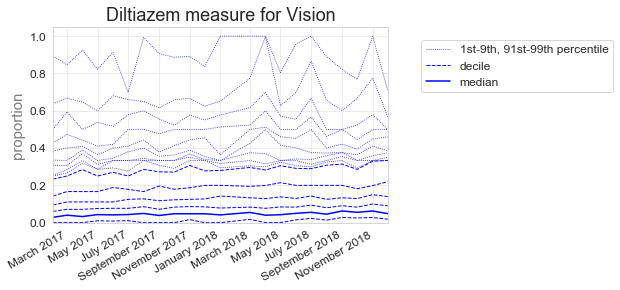

In [47]:
from ebmdatalab import charts
plt = charts.deciles_chart(
        df,
        period_column='month',
        column='calc_value',
        title="Diltiazem measure nationally",
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=True
    )
plt.show()
    
for supplier in ['EMIS', 'TPP', 'Microtest', 'Vision']:
    plt = charts.deciles_chart(
        df[df['supplier'] == supplier],
        period_column='month',
        column='calc_value',
        title="Diltiazem measure for {}".format(supplier),
        ylabel="proportion",
        show_outer_percentiles=True,
        show_legend=True
    )
    plt.show()

In [48]:
df.rename(columns={'pct_id':'pct'}, inplace=True)  # The CCG column must be named 'pct' for the maps function

In [49]:
by_pct = df.groupby('pct').sum().reset_index()
by_pct['calc_value'] = by_pct['numerator'] / by_pct['denominator']
by_supplier_and_pct = df.groupby(['supplier', 'pct']).sum().reset_index()
by_supplier_and_pct['calc_value'] = by_supplier_and_pct['numerator'] / by_supplier_and_pct['denominator']

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


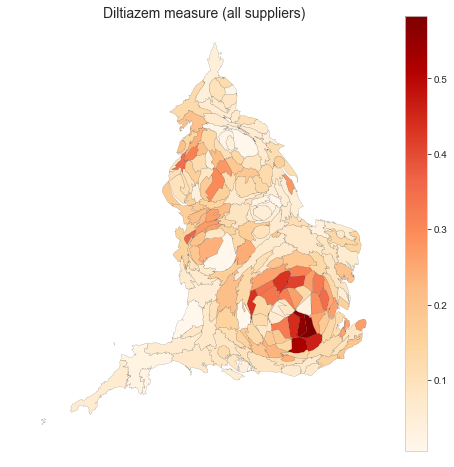

In [50]:
from ebmdatalab import maps
importlib.reload(maps)

fig = maps.ccg_map(by_pct, title="Diltiazem measure (all suppliers)", column='calc_value', cartogram=True)


/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


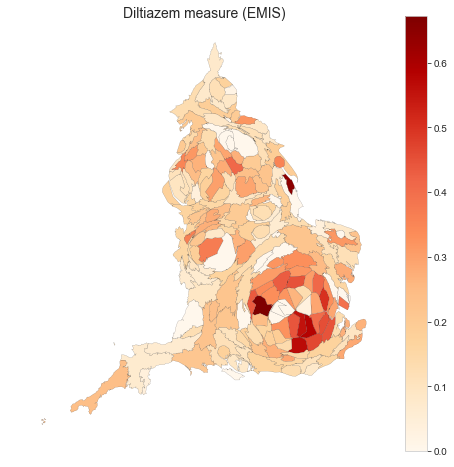

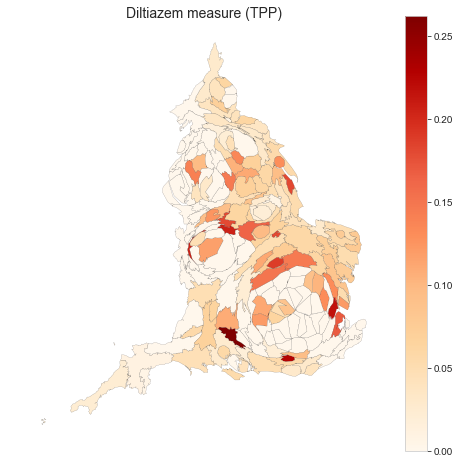

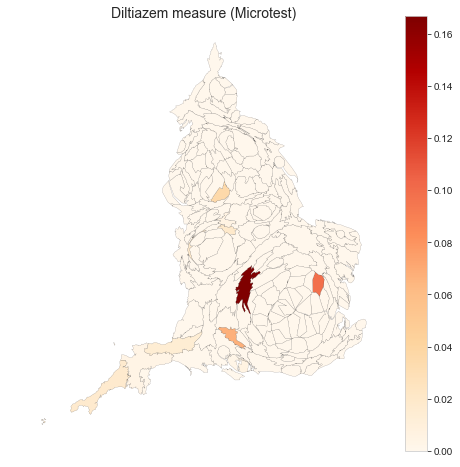

In [51]:
for supplier in ['EMIS', 'TPP', 'Microtest']:
    data = by_supplier_and_pct[by_supplier_and_pct['supplier'] == supplier]
    plt = maps.ccg_map(data, title="Diltiazem measure ({})".format(supplier), column='calc_value', cartogram=True)
    plt.show()